<a href="https://colab.research.google.com/github/rishabh-mondal/brick_klins/blob/main/BALD_C%26D_AL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import os, cv2, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from random import shuffle
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
traindata= '/content/drive/MyDrive/archive/test'
cats_dir = '/content/drive/MyDrive/archive/test/cat'
dogs_dir = '/content/drive/MyDrive/archive/test/dog'
testdata='/content/drive/MyDrive/archive/train'


In [4]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class_labels = {'cat': 0, 'dog': 1}

data = []
labels = []

for filename in os.listdir(cats_dir):
    if filename.endswith(".jpg"):
        img_path = os.path.join(cats_dir, filename)
        img = load_img(img_path, target_size=(224, 224))  # Resize as needed
        img_array = img_to_array(img)
        data.append(img_array)
        labels.append(class_labels['cat'])

for filename in os.listdir(dogs_dir):
    if filename.endswith(".jpg"):
        img_path = os.path.join(dogs_dir, filename)
        img = load_img(img_path, target_size=(224, 224))  # Resize as needed
        img_array = img_to_array(img)
        data.append(img_array)
        labels.append(class_labels['dog'])

data = np.array(data)
labels = np.array(labels)

one_hot_labels = to_categorical(labels, num_classes=len(class_labels))

print("Data shape:", data.shape)
print("One-hot labels shape:", one_hot_labels.shape)


Data shape: (617, 224, 224, 3)
One-hot labels shape: (617, 2)


In [5]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(data, one_hot_labels, test_size=0.2, random_state=42)
train_X, pool_X, train_y, pool_y = train_test_split(train_X, train_y, train_size=0.05, random_state=42)

print("Train data shape:", train_X.shape)
print("Train labels shape:", train_y.shape)
print("Pool data shape:", pool_X.shape)
print("Pool labels shape:", pool_y.shape)
print("Test data shape:", test_X.shape)
print("Test labels shape:", test_y.shape)


Train data shape: (24, 224, 224, 3)
Train labels shape: (24, 2)
Pool data shape: (469, 224, 224, 3)
Pool labels shape: (469, 2)
Test data shape: (124, 224, 224, 3)
Test labels shape: (124, 2)


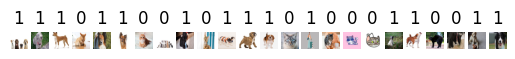

In [6]:
import matplotlib.pyplot as plt

num_images_to_display = 24

for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i+1)
    plt.imshow(train_X[i].astype('uint8'))
    plt.title(f'{train_y[i].argmax()}')  # Display the one-hot label as class
    plt.axis('off')

plt.show()


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [7]:
def entropy(p):
    return -np.sum(p * np.log2(p + 1e-10), axis=1)

In [8]:
def random_sample(p,number_of_sample=1):
    num_samples = p.shape[0]
    sample = np.random.choice(num_samples, size=number_of_sample, replace=False)
    return sample

In [9]:
def BAlD(Y):
    E_p = Y.mean(axis=1)
    E_p_log_p = np.sum(E_p * np.log2(E_p), axis=1)
    E_p_log_1_p = np.sum((1 - E_p) * np.log2(1 - E_p), axis=1)
    return E_p_log_p - E_p_log_1_p

def mc_dropout_predictions(model, X, num_samples=5):
    predictions = []
    for _ in range(num_samples):
        output = model.predict(X, batch_size=32)  # You might need to adjust the batch_size
        predictions.append(output)
    return np.array(predictions)

In [12]:

def active_learning(train_X, train_y, pool_X_train, pool_y_train, pool_X_test, y_test, acquisition_function, num_iterations, number_of_sample=1):
    new_indices_list = []
    accuracy_iteration = []

    for iter in range(num_iterations):
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            MaxPooling2D(2, 2),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(2, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy')
        model.fit(train_X, train_y, epochs=10, batch_size=32, verbose=0)

        pool_probabilities = model.predict(pool_X_train)
        y_pred_classes = np.argmax(pool_probabilities, axis=1)

        acquisition_scores = acquisition_function(pool_probabilities)

        selected_indices = np.argsort(acquisition_scores)[-number_of_sample:]

        labeled_X = pool_X_train[selected_indices]
        labeled_y = pool_y_train[selected_indices]

        new_indices_list.append(selected_indices)

        train_X = np.concatenate((train_X, labeled_X), axis=0)
        train_y = np.concatenate((train_y, labeled_y), axis=0)

        pool_X_train = np.delete(pool_X_train, selected_indices, axis=0)
        pool_y_train = np.delete(pool_y_train, selected_indices)

        y_pred_probabilities = model.predict(pool_X_test)
        threshold = 0.5
        binary_predictions = np.where(y_pred_probabilities > threshold, 1, 0)

        accuracy = accuracy_score(y_test, binary_predictions)
        accuracy_iteration.append(accuracy)

    return accuracy_iteration, new_indices_list

In [15]:

def active_learningBALD(train_X, train_y, pool_X_train, pool_y_train, pool_X_test, y_test, num_iterations, number_of_sample=1):
    new_indices_list = []
    accuracy_iteration = []

    for iter in range(num_iterations):
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            MaxPooling2D(2, 2),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(2, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy')
        model.fit(train_X, train_y, epochs=10, batch_size=32, verbose=0)

        pool_probabilities = mc_dropout_predictions(model, pool_X_train)
        # uncertainty = np.var(pool_probabilities, axis=0).sum(axis=1)
        acquisition_scores = BAlD(pool_probabilities)
        y_pred_classes = np.argmax(pool_probabilities, axis=1)

        selected_indices = np.argsort(acquisition_scores)[-number_of_sample:]

        labeled_X = pool_X_train[selected_indices]
        labeled_y = pool_y_train[selected_indices]

        new_indices_list.append(selected_indices)

        train_X = np.concatenate((train_X, labeled_X), axis=0)
        train_y = np.concatenate((train_y, labeled_y), axis=0)

        pool_X_train = np.delete(pool_X_train, selected_indices, axis=0)
        pool_y_train = np.delete(pool_y_train, selected_indices)

        y_pred_probabilities = model.predict(pool_X_test)
        threshold = 0.5
        binary_predictions = np.where(y_pred_probabilities > threshold, 1, 0)

        accuracy = accuracy_score(y_test, binary_predictions)
        accuracy_iteration.append(accuracy)

    return accuracy_iteration, new_indices_list

In [ ]:
accuracy_iteration, new_indices_list = active_learningBALD(train_X, train_y, pool_X,pool_y,test_X,test_y , num_iterations=10, number_of_sample=1)


In [ ]:

for iteration, (accuracy, selected_indices) in enumerate(zip(accuracy_iteration, new_indices_list), 1):
    print(f"Iteration {iteration}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Selected indices: {selected_indices}")

In [ ]:
accuracy_iteration2, new_indices_list2 = active_learning(train_X, train_y, pool_X,pool_y,test_X,test_y ,entropy, num_iterations=10, number_of_sample=1)
accuracy_iteration1, new_indices_list1 = active_learning(train_X, train_y, pool_X,pool_y,test_X,test_y ,random_sample, num_iterations=10, number_of_sample=1)

for iteration, (accuracy, selected_indices) in enumerate(zip(accuracy_iteration, new_indices_list), 1):
    print(f"Iteration {iteration}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Selected indices: {selected_indices}")

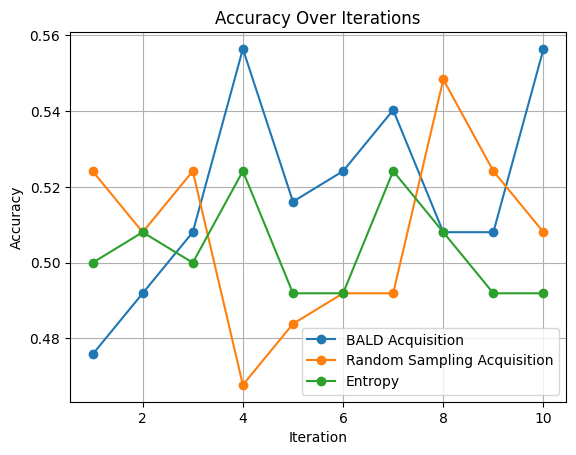

In [25]:
plt.plot(range(1, len(accuracy_iteration) + 1), accuracy_iteration, marker='o', label='BALD Acquisition')
plt.plot(range(1, len(accuracy_iteration) + 1), accuracy_iteration1, marker='o', label='Random Sampling Acquisition')
plt.plot(range(1, len(accuracy_iteration) + 1), accuracy_iteration2, marker='o', label='Entropy')

plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Iterations')
plt.grid()
plt.legend()
plt.show()

In [50]:
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

def active_learning(train_X, train_y, pool_X_test, y_test, num_iterations):
    accuracy_iteration = []

    for iter in range(num_iterations):
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            MaxPooling2D(2, 2),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(2, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy')
        # print(train_X.shape)
        # print(train_y.shape)
        # print(pool_X_test.shape)
        model.fit(train_X, train_y, epochs=10, batch_size=32, verbose=0)

        pool_probabilities = model.predict(pool_X_test)
        threshold = 0.5
        binary_predictions = np.where(pool_probabilities > threshold, 1, 0)
        # print(pool_probabilities.dtype)
        # print(type(y_test))

        # print(y_pred_classes[0])
        # print(y_test.shape)
        # print(y_test.dtype)

        accuracy = accuracy_score(y_test, binary_predictions)
        accuracy_iteration.append(accuracy)

    return accuracy_iteration


In [51]:
accuracy_iteration = active_learning(train_X, train_y, pool_X, pool_y, num_iterations=5)

print("Accuracy Iterations:", accuracy_iteration)

15/15 [==============================] - 0s 17ms/step
Accuracy Iterations: [0.5501066098081023, 0.5031982942430704, 0.5181236673773987, 0.4946695095948827, 0.5309168443496801]
